In [2]:
import pandas as pd
from hydra import initialize, compose
from pathlib import Path
from ergochemics.draw import draw_reaction, draw_molecule
from IPython.display import SVG
from rdkit import Chem
import matplotlib.pyplot as plt
import numpy as np
to_nested_lists = lambda x: [[arr.tolist() for arr in side] for side in x]


In [3]:
with initialize(version_base=None, config_path="../configs/filepaths"):
    cfg = compose(config_name="filepaths")

In [4]:
mm = pd.read_parquet(
    Path(cfg.raw_data) / "mapped_mech_labeled_reactions.parquet"
)
mm.head()

,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
0,1,1,NC(CCC(=O)O)C(=O)O>>NC(CCC(=O)O)C(=O)O,[NH2:5][CH:1]([CH2:3][CH2:2][C:4](=[O:9])[OH:1...,[#6:1]-[#6:2]-[#6:3]-[#6:4]>>[#6:1]-[#6:3]-[#6...,"[[[1, 2, 3, 4]], [[0, 1, 2, 3]]]","[[1, 7, 8, 9]]",glutamate racemase,P56868,5.1.1.3
1,2,2,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"[[[5, 7], [0]], [[0, 1, 2]]]","[[5, 6, 7], [0]]",beta-lactamase (Class A),P62593,3.5.2.6
2,2,1,*C(=O)NC1C(=O)N2C1SC(C)(C)C2C(=O)O.O>>*C(=O)NC...,[*:10][C:8](=[O:11])[NH:6][CH:4]1[C:2](=[O:5])...,[#6:1]-[#7:2].[#8:3]>>([#7:2].[#6:1]-[#8:3]),"[[[5, 7], [0]], [[0, 1, 2]]]","[[5, 6, 7], [0]]",beta-lactamase (Class A),P62593,3.5.2.6
3,6,1,NC(CCC(=O)NC(CSSCC(NC(=O)CCC(N)C(=O)O)C(=O)NCC...,[NH2:17][CH:14]([CH2:12][CH2:9][C:6](=[O:10])[...,[#16:1]-[#16:2].[#6:3]1=[#6:4]-[#7:5]-[#6:6]=[...,"[[[9, 10], [3, 4, 5, 45, 46, 47]], [[0], [0], ...","[[9, 10], [3, 4, 5, 47]]",glutathione-disulfide reductase,P00390,1.8.1.7
4,7,2,NC(=O)c1ccc[n+](C2OC(COP(=O)(O)OP(=O)(O)OCC3OC...,[NH2:18][C:17](=[O:19])[c:11]1[cH:16][cH:15][c...,[#6:1]1:[#6:2]:[#6:3]:[#6:4]:[#7+:5]:[#6:6]:1....,"[[[3, 4, 5, 6, 7, 47], [7, 5, 4, 8, 9]], [[0, ...","[[3, 4, 7, 47], [4, 5, 7, 8, 9, 12]]",isocitrate dehydrogenase (NADP+),P08200,1.1.1.42


In [5]:
min_rules = pd.read_csv(
    filepath_or_buffer=Path(cfg.artifacts) / "rules" / "min_rules.tsv",
    sep="\t",
)
min_rules.head()

,Name,Reactants,SMARTS,Products,Comments
0,rule0001,Any;Any,[#6:1]-[#8:2].[#8:3]>>[#6:1]-[#8:3].[#8:2],Any;Any,A0A060PLD9;A0A0P0YNP7;A0A0P9RZM9;A1XCQ0;A3E242...
1,rule0002,Any;NAD_CoF,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,NADH_CoF;Any,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
2,rule0003,NADH_CoF;Any,[#6:1]1=[#6:2]-[#7:3]-[#6:4]=[#6:5]-[#6:6]-1.[...,Any;NAD_CoF,A0A023RBJ1;A0A060KZ16;A0A060TBM3;A0A072UJB3;A0...
3,rule0004,Any;NADH_CoF;O2,[#6:1].[#6:2]1=[#6:3]-[#7:4]-[#6:5]=[#6:6]-[#6...,Any;NAD_CoF;WATER,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...
4,rule0005,Any;NAD_CoF;WATER,[#6:1]-[#8:2].[#6:3]1:[#6:4]:[#6:5]:[#6:6]:[#7...,Any;NADH_CoF;O2,A0A1P8W705;A0A250DUW2;A1Z745;A5HMH6;A5HMH7;A5H...


In [6]:
decarb_rule = min_rules.loc[min_rules['Name'] == 'rule0024', "SMARTS"].iloc[0]

In [12]:
decarb_rule

'[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3]'

In [7]:
mcsa_decarbs = mm.loc[mm['rule'] == decarb_rule]
print(len(mcsa_decarbs))
mcsa_decarbs.head()

29


,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
33,49,1,NC(Cc1c[nH]cn1)C(=O)O>>NCCc1c[nH]cn1.O=C=O,[NH2:2][CH:1]([CH2:3][c:4]1[cH:5][nH:7][cH:8][...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"[[[1, 8, 10]], [[0], [0, 1]]]","[[0, 1, 8, 10]]",histidine decarboxylase,P00862,4.1.1.22
34,50,1,O=C(O)c1cc(=O)[nH]c(=O)n1C1OC(COP(=O)(O)O)C(O)...,[O:24]=[C:22]([OH:23])[c:1]1[cH:2][c:4](=[O:7]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"[[[3, 1, 2]], [[0], [0, 1]]]","[[1, 2, 3]]",orotidine-5'-phosphate decarboxylase,P25971,4.1.1.23
35,50,3,O=C(O)c1cc(=O)[nH]c(=O)n1C1OC(COP(=O)(O)O)C(O)...,[O:24]=[C:22]([OH:23])[c:1]1[cH:2][c:4](=[O:7]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"[[[3, 1, 2]], [[0], [0, 1]]]","[[1, 2, 3, 4]]",orotidine-5'-phosphate decarboxylase,P25971,4.1.1.23
36,50,2,O=C(O)c1cc(=O)[nH]c(=O)n1C1OC(COP(=O)(O)O)C(O)...,[O:24]=[C:22]([OH:23])[c:1]1[cH:2][c:4](=[O:7]...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"[[[3, 1, 2]], [[0], [0, 1]]]","[[3, 4, 5, 6]]",orotidine-5'-phosphate decarboxylase,P25971,4.1.1.23
50,70,1,CC(C(=O)O)C(=O)SCCNC(=O)CCNC(=O)C(O)C(C)(C)COP...,[CH3:2][CH:1]([C:53](=[O:55])[OH:54])[C:3](=[O...,[#6:1]-[#6:2]-[#8:3]>>[#6:1].[#6:2]=[#8:3],"[[[1, 2, 4]], [[0], [0, 1]]]","[[1, 2, 4, 5, 6]]",methylmalonyl-CoA decarboxylase,P52045,7.2.4.3


Showing example: 49, 1


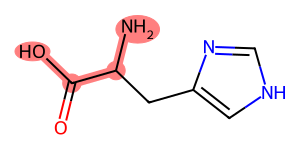

Showing example: 50, 1


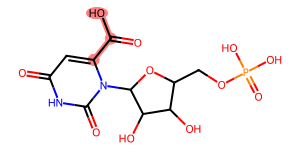

Showing example: 50, 3


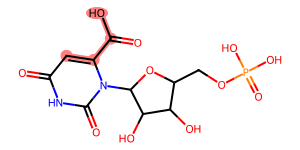

Showing example: 50, 2


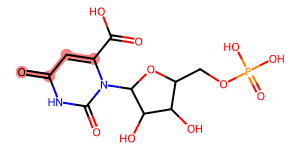

Showing example: 70, 1


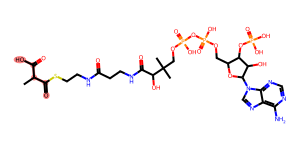

Showing example: 72, 1


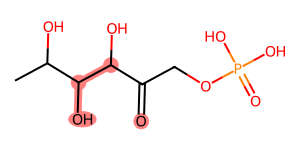

Showing example: 182, 1


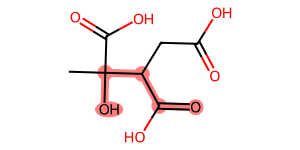

Showing example: 182, 2


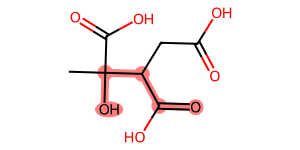

Showing example: 182, 3


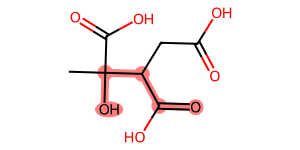

Showing example: 182, 4


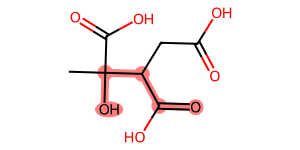

Showing example: 215, 1


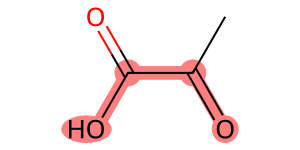

Showing example: 217, 1


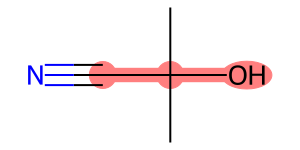

Showing example: 220, 2


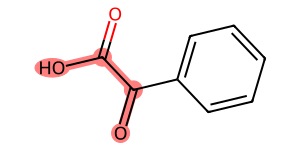

Showing example: 220, 3


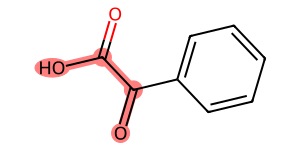

Showing example: 220, 1


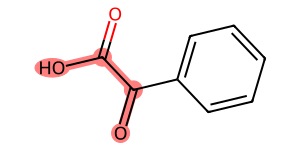

Showing example: 221, 1


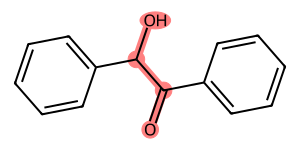

Showing example: 225, 1


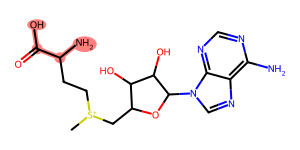

Showing example: 231, 1


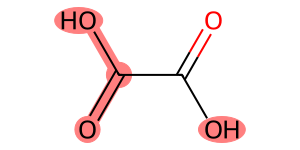

Showing example: 236, 1


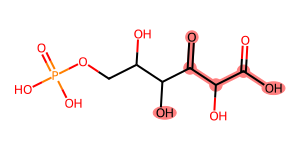

Showing example: 236, 2


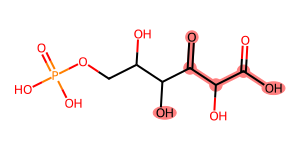

Showing example: 409, 2


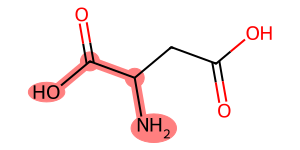

Showing example: 639, 1


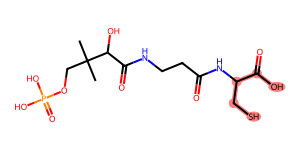

Showing example: 645, 1


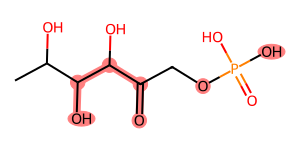

Showing example: 652, 1


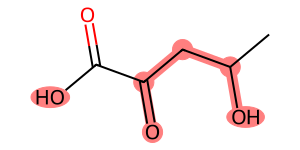

Showing example: 664, 1


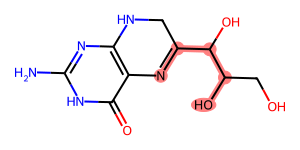

Showing example: 675, 1


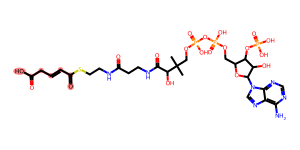

Showing example: 846, 1


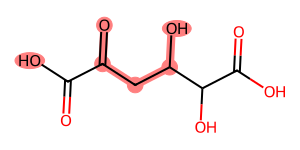

Showing example: 941, 1


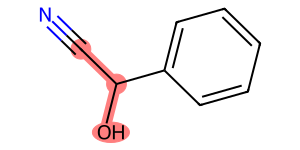

Showing example: 992, 1


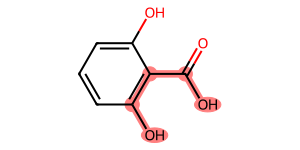

In [8]:
for i, row in mcsa_decarbs.iterrows():
    smarts = row["smarts"]
    reaction_center = to_nested_lists(row["reaction_center"])
    mech_atoms = row["mech_atoms"][0].tolist()
    rct = Chem.MolFromSmiles(smarts.split('>>')[0])
    print(f"Showing example: {row["entry_id"]}, {row["mechanism_id"]}")
    img = draw_molecule(rct, size=(300, 150), highlight_atoms=mech_atoms)
    display(SVG(img))

    with open(Path(cfg.artifacts) / "imgs" / "mcsa_decarbs" / f"{row['entry_id']}_{row['mechanism_id']}.svg", "w") as f:
        f.write(img)

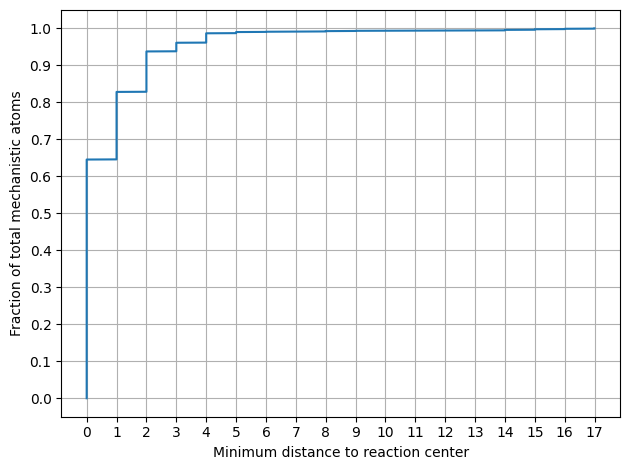

In [9]:
tmp = []
for i, row in mm.iterrows():
    smarts = row["smarts"]
    lhs_mols = [Chem.MolFromSmiles(elt) for elt in smarts.split('>>')[0].split('.')]
    lrc = to_nested_lists(row["reaction_center"])[0]
    mech_atoms = [elt.tolist() for elt in row["mech_atoms"]]
    for mol, rc, mech in zip(lhs_mols, lrc, mech_atoms):
        for aidx in mech:
            min_dist = min(len(Chem.GetShortestPath(mol, aidx, rcidx)) - 1 if aidx != rcidx else 0 for rcidx in rc)
            tmp.append((min_dist, row["entry_id"], row["mechanism_id"]))

min_dists_to_rc = sorted([x[0] for x in tmp])
df = pd.DataFrame(tmp, columns=["min_dist_to_rc", "entry_id", "mechanism_id"]).sort_values(by="min_dist_to_rc", ascending=False)
ycdf = np.arange(len(min_dists_to_rc)) / len(min_dists_to_rc)

fig, ax = plt.subplots()
ax.plot(min_dists_to_rc, ycdf)
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_xticks(np.arange(0, max(min_dists_to_rc) + 1, 1))
ax.set_xlabel("Minimum distance to reaction center")
ax.set_ylabel("Fraction of total mechanistic atoms")
ax.grid()
plt.tight_layout()
plt.show()

In [10]:
df.head()

,min_dist_to_rc,entry_id,mechanism_id
447,17,116,1
445,17,116,1
446,16,116,1
444,16,116,1
959,16,291,1


In [11]:
row = mm.loc[(mm["entry_id"] == 116) & (mm["mechanism_id"] == 1)]
smarts = row["smarts"]
reaction_center = to_nested_lists(row["reaction_center"])
mech_atoms = row["mech_atoms"][0].tolist()
rct = Chem.MolFromSmiles(smarts.split('>>')[0])
print(f"Showing example: {row["entry_id"]}, {row["mechanism_id"]}")
display(SVG(draw_molecule(rct, size=(300, 150), highlight_atoms=mech_atoms)))

KeyError: 0

In [ ]:
row

,entry_id,mechanism_id,smarts,am_smarts,rule,reaction_center,mech_atoms,enzyme_name,uniprot_id,ec
78,116,1,NC(=O)C1=CN(C2OC(COP(=O)(O)OP(=O)(O)OCC3OC(n4c...,[NH2:88][C:86](=[O:89])[C:84]1=[CH:82][N:80]([...,[#8:1].[#8:2]-[#15:3]>>[#8:2].[#8:1]-[#15:3],"[[[34], [36, 37]], [[0], [0, 1]]]","[[5, 41, 42, 43], [3, 4, 7, 47]]",NAD(P)+ transhydrogenase (AB-specific),"Q2RSB2, Q2RSB4",1.6.1.2
